In [1]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax 
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data  = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
    
    #To compare data which we dont have 
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def nxt_batch(self, batch_size, steps, return_batch_ts = False):
        
        #Get a random starting point to the batch size 
        rand_start = np.random.rand(batch_size, 1)
        
        #Make the point fall on the time series
        ts_start  = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
        
        #Create a batch of data
        batch_ts = ts_start + np.arange(0.0, steps + 1) * self.resolution
        
        y_batch = np.sin(batch_ts)
        
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)
        

In [7]:
ts_data = TimeSeriesData(250, 0, 10)

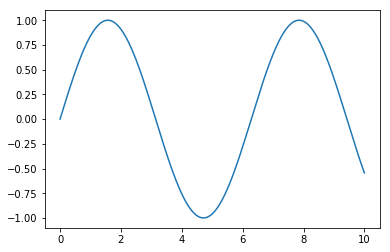

In [8]:
plt.plot(ts_data.x_data, ts_data.y_true)

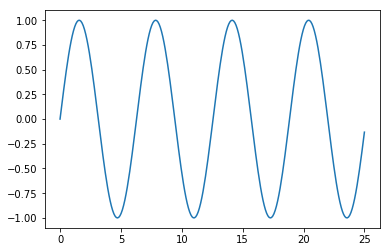

In [9]:
ts_data = TimeSeriesData(250, 0, 25)
plt.plot(ts_data.x_data, ts_data.y_true)

In [23]:
num_steps = 30
y1, y2, ts = ts_data.nxt_batch(1, num_steps,True)

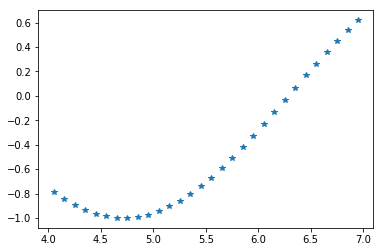

In [24]:
plt.plot(ts.flatten()[1:,],y2.flatten(), '*' )

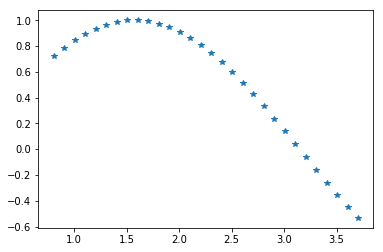

In [52]:
num_steps = 30
y1, y2, ts = ts_data.nxt_batch(1, num_steps,True)
plt.plot(ts.flatten()[1:,],y2.flatten(), '*' )

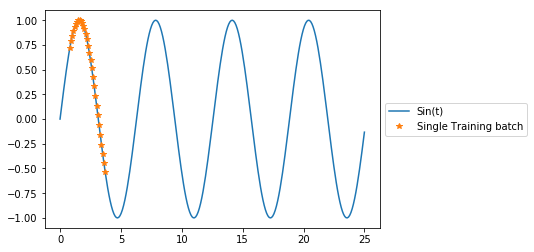

In [53]:
plt.plot(ts_data.x_data, ts_data.y_true, label = 'Sin(t)')
plt.plot(ts.flatten()[1:,], y2.flatten(), '*', label='Single Training batch')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()


In [54]:
train_data = np.linspace(5, 5 + ts_data.resolution * (num_steps + 1), num_steps + 1)

In [55]:
train_data[:-1]


array([ 5.        ,  5.10333333,  5.20666667,  5.31      ,  5.41333333,
        5.51666667,  5.62      ,  5.72333333,  5.82666667,  5.93      ,
        6.03333333,  6.13666667,  6.24      ,  6.34333333,  6.44666667,
        6.55      ,  6.65333333,  6.75666667,  6.86      ,  6.96333333,
        7.06666667,  7.17      ,  7.27333333,  7.37666667,  7.48      ,
        7.58333333,  7.68666667,  7.79      ,  7.89333333,  7.99666667])

In [56]:
train_data

array([ 5.        ,  5.10333333,  5.20666667,  5.31      ,  5.41333333,
        5.51666667,  5.62      ,  5.72333333,  5.82666667,  5.93      ,
        6.03333333,  6.13666667,  6.24      ,  6.34333333,  6.44666667,
        6.55      ,  6.65333333,  6.75666667,  6.86      ,  6.96333333,
        7.06666667,  7.17      ,  7.27333333,  7.37666667,  7.48      ,
        7.58333333,  7.68666667,  7.79      ,  7.89333333,  7.99666667,
        8.1       ])

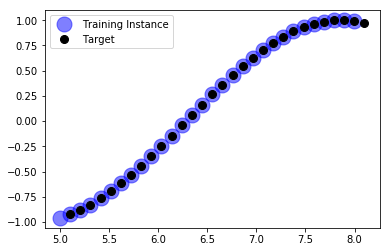

In [58]:
plt.plot(train_data[:-1], ts_data.ret_true(train_data[:-1]),'bo', markersize = 15, alpha = 0.5, label = 'Training Instance')

plt.plot(train_data[1:], ts_data.ret_true(train_data[1:]), 'ko', markersize = 8, label = 'Target')

plt.legend()

In [59]:
tf.reset_default_graph()

In [60]:
num_ip = 1

In [61]:
num_neurons = 100

In [62]:
num_op = 1

In [63]:
learning_rate = 0.001 

In [64]:
num_train_iterations = 2000

In [65]:
batch_size = 1

In [69]:
# Place holders 
##NONE is the batch size for that dimension 

In [70]:
X = tf.placeholder(tf.float32,[None, num_steps, num_ip])

In [71]:
y = tf.placeholder(tf.float32, [None, num_steps, num_op])

In [73]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu)
##Since we are using 100 neurons the RNN model will spit out 100 outputs, as in 
#our code sample we will be needing only 
#one output, Hence we will be using a output wrapper fucntion 
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_op)

In [75]:
##Dynamic RNN  = spits states & outputs of the cell 
#it unrolls the inputs -> which means that it uses while loop to 
#run over the cell appropriate num of times 
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [76]:
# Loss Function - we will be using MSE for loss function 
loss = tf.reduce_mean(tf.square(outputs - y))

In [77]:
# for optimizer -> User AdamOptimizer 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [78]:
train = optimizer.minimize(loss)